In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state=42
%matplotlib inline

## Библиотека Vowpal Wabbit

Еще одним подходом для работы с текстовым данными является использование библиотеки [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki).

VW представляет из себя хорошую реализация стохастического градиентного спуска для линейных моделей. К преимуществам и особенностям данной библиотеки можно отнести:
 - Считывание с диска происходит батчами, VW делает каждый следующий шаг градиентного спуска только по батчу, поэтому нет необходимости хранить всю выборку в памяти, из-за чего его удобно применять для больших выборок при ограниченных ресурсах.
 - Из коробки работают: нормализация признаков, взвешивание объектов, адаптивный градиентный шаг, матричные разложения, тематическое моделирование, активное обучение, обучение с подкреплением.
 - Реализация VW содержит различные методы оптимизации: сопряженные градиенты, квазиньютоновские методы (L-BFGS).
 - VW может быть запущен на кластере.

Перед началом работы с vw полезно будет ознакомиться с информацией по ссылкам:
 - [Ноутбук с семинара про VW (ближе к концу)](https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/7szdykca8mzyngz/bow_vw.ipynb)
 - [Туториал по VW](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)
 - [Описание формата входных данных](https://github.com/JohnLangford/vowpal_wabbit/wiki/Input-format)
 - [Описание параметров командной строки](https://github.com/JohnLangford/vowpal_wabbit/wiki/Command-line-arguments)

Приведите обучающую и тестовую выборки к формату пригодному для обучения модели с помощью vw: в качестве признаков используйте тексты вопросов как есть.

Загрузим данные, приведем к двухклассовой классификации и размделим тестовую и трейновую выборки

In [2]:
X_train_initial = pd.read_csv('../data3/X_train.csv').set_index('id')
y_train_initial = pd.read_csv('../data3/y_train.csv').set_index('id')

In [3]:
y_train_p = y_train_initial.copy()
y_train_p['name'] = y_train_initial['name'].str.contains(r'\bpython\b').astype(int)

In [4]:
xy = X_train_initial.join(y_train_p)

Напишем конвертор датафрейма к виду VW

In [78]:
def convertDataFrameToVWFormat(xyDF, labelColName, trueLabel):    
    # remove '|' and ':' that are special characters in VW
    def clean(s):
        return s.replace("|", "").replace(":", "").replace("\n", " ")

    def parseRow(row):
        line = ""
        # convert labels to 1s and -1s and add to the beginning of the line        
        label = 1 if row[labelColName] == trueLabel else -1
        line += "{} {}".format(1 if row[labelColName] == trueLabel else -1, row.name)    

        for colName in featureCols:    
            line += "|{} {} ".format(colName, clean(str(row[colName])))

        return line

    # select feature columns
    featureCols = [c for c in xyDF.columns if c != labelColName]

    return xyDF.apply(parseRow , axis = 1)

In [79]:
df_wv = convertDataFrameToVWFormat(xy, 'name', 1)

In [100]:
df_full = df_wv.to_frame().join(xy)

In [109]:
xy_train, xy_test = train_test_split(df_full, test_size=0.3, random_state=random_state)

В тесте и трейне у нас будут ответы, но для теста будем запускать с параметром `-t` 

In [57]:
np.savetxt('vw_train.txt', np.array(xy_train['0']), fmt="%s")
np.savetxt('vw_test.txt', np.array(xy_test['0']), fmt="%s")

### Задание

**(1.5 балла)**

Обучите Vowpal Wabbit на полученной выборке. В качестве функции потерь (параметр [loss_function](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)) попробуйте использовать:
  - логистическую (logistic)
  - кусочно-линейную (hinge)

Постройте *Precision-Recall* и *ROC* кривые для каждой из получившихся моделей. Сравните время обучения и получившееся качество со временем обучения и качеством предыдущих моделей.

Обучение производим по следующему шаблону:

`vw -d vw_train.txt -P 10000 --loss_function=logistic -p logistic_train.txt -f model_logistic`

Тестирование:

`vw -d vw_test.txt -P 10000 --loss_function=logistic -p logistic_prediction.txt -t -i model_logistic`

Для измерения времени используем функцию time. `time (command)`

In [132]:
def get_prediction(filename):
    prediction = []
    with open(filename) as pred_file:
        for line in pred_file.readlines():
            pred, tag = line.strip().split(" ")
            prediction.append([float(pred), int(tag)])
    return pd.DataFrame(prediction, columns=["prob", "id"]).set_index('id')

Загрузим результирующие вероятности 

In [134]:
y_pred_log = get_prediction('logistic_prediction.txt')
y_pred_hinge = get_prediction('hinge_prediction.txt')

/Users/eandreyf/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


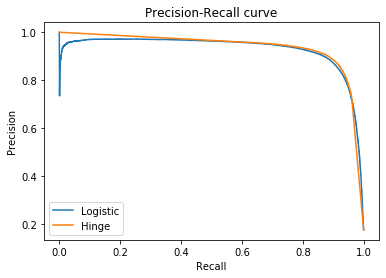

In [137]:
from sklearn.metrics import roc_curve, precision_recall_curve

precision_log, recall_log, _ = precision_recall_curve(xy_test['name'], y_pred_log['prob'])
plt.plot(recall_log, precision_log, label='Logistic')

precision_hinge, recall_hinge, _ = precision_recall_curve(xy_test['name'], y_pred_hinge['prob'])
plt.plot(recall_hinge, precision_hinge, label='Hinge')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall curve')
plt.legend()

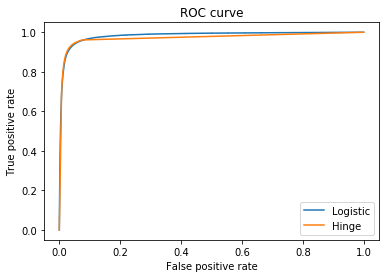

In [138]:
fpr_log, tpr_log, _ = roc_curve(xy_test['name'], y_pred_log['prob'])
plt.plot(fpr_log, tpr_log, label='Logistic')

fpr_hinge, tpr_hinge, _ = roc_curve(xy_test['name'], y_pred_hinge['prob'])
plt.plot(fpr_hinge, tpr_hinge, label='Hinge')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()

In [139]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

print('Log ROC', roc_auc_score(xy_test['name'], y_pred_log['prob']), 'PR', auc(recall_log, precision_log))
print('Hingle ROC', roc_auc_score(xy_test['name'], y_pred_hinge['prob']), 'PR', auc(recall_hinge, precision_hinge))


Log ROC 0.9825942780553405 PR 0.9291357208959393
Hingle ROC 0.9714560918248468 PR 0.9373917163355643


Время обучения:

`hinge: 10.73s, log: 11.48s`

Получаем огромное преимущество по скорости и, при этом, высокое качество относительно предыдущих моделей

## Выводы

### Задание

**(1 балл)**

В первой части лабораторной работы мы рассмотрели 2 способа подбора гиперпараметров и калибровки алгоритмов машинного обучения. Ответьте на следующие вопросы:

- В каких случаях случайный поиск гиперпараметра имеет преимущество, в сравнении с перебором по сетке? Приведите пример такого случая.
- Для какого типа задач машинного обучения имеет смысл использовать калибровку предсказаний? Приведите пример такой задачи.

Приведенные примеры не должны совпадать с упомянутыми ранее в работе.

### Случайный поиск
Случайный поиск предпочтительнее использовать, когда тестирование каждого набора гиперпараметров ресурсозатратно и мы вынуждены ограничиваться небольшим набором вариантов. В этом случае мы можем рассмотреть больше разнообразных значений каждого гиперпараметра, тем самым найти пики, которые находятся между значениями сетки. Тем не менее случайный поиск не гарантирует улучшение подбора и стабильность подбора.
**Пример:** выборка распределенная по нормальному распределению (3 - матожидание, 1 - дисперсия) на интервале `(0, 600)`. Вероятность попасть в интервал `(0, 6)` - там где содержится `99%` значений `6/600=1%`. Возьмём эквивалентный бюджет в 100 для равномерного поиска по сетке. В этом случае, наибольшее значение будет `600/101=5.94`. Вероятность того, что результат случайного поиска будет лучше поиска по сетке `(6-0.12)/600*100)=98%`

### Калибровка предсказаний
Калибровка предсказаний требуется, если целевая метрика требует вероятности, например определение риска заболевания коронавирусом при контакте с больным. В этом случае нам важно не упустить случаи, чем гипердиагностировать и подбирая порог вероятности мы определяем приоритет гипердиагностики

### Задание

**(1 балл)**

В второй части лабораторной работы мы рассмотрели несколько методов работы с текстовыми данными. Ответьте на следующие вопросы:

- Какие есть достоинства у рассмотренных методов представления текстовых данных? Поясните свой ответ для каждого рассмотренного метода.
- Каким общим недостатком обладают данные методы?
- Какие модели машинного обучения больше подходят для работы с текстовыми данными на практике и почему? В чём их преимущество перед другими алгоритмами?

In [ ]:
Все рассмотренные методы считают каждое слово как отдельную фичу. Они отличаются тем, как сокращают количество фичей и как считают значение для каждой фичи.

Оптимизация количества фичей:
1. *Без оптимизации*. Не теряет фичи, рассматривает всё множество слов.
2. *Выбор наиболее важных слов*. Отбирает только те слова, которые оказывают наибольшее влияние на разделение объектов. Ускоряет сходимость, убирает шумы.
3. *Выбор наиболее частых слов*. Отбирает наиболее используемые слова. Что чаще используется, то потенциально имеет больше значение. Ускоряет сходимость, убирает шумы.
4. *Заранее заданный размер хеша слов*. Заданный размер словаря. Уменьшает занимаемое место. Возможность обучаться на новых данных

Значение по каждой фиче:
1. *Количество слов*. Более частые слова имеют больший вес
2. *Логарифм количества слов*. Сглаживание разброса частот
3. *tf-idf*. Способ без учёта классификатора выявить важные слова и дать им больший вес

Использование библиотеки Vowpal Wabbit: совмещает в себе преимущества описанных выше методов и добавляет ещё свои методы оптимизации, которые дают улучшение качества при уменьшении времени обучения

Все эти методы работают с каждым словом в отдельности, но не рассматривают словосочетания и не анализируют смысл. Так же они плохо вычленяют смысловую составляющую и техническую. Например, важно отличать `c++` от `с#`, но совсем не важно `a++` и `a#`.

Мы рассмотрели две модели: случайный лес и линейную модель. На стандартном подборе гиперпараметров обе модели показали себя одинаково. Однако методы линейной модели существенно быстрее работают, требуют меньше памяти на хранение моделей, имеют больше настроек для оптимизации. Это доказывается использованием библиотеки VW, которая очень быстро смогла дать лучше результат при обработке сильно больших данных.

Все эти методы работают с каждым словом в отдельности, но не рассматривают словосочетания и не анализируют смысл. Так же они плохо вычленяют смысловую составляющую и техническую. Например, важно отличать `c++` от `с#`, но совсем не важно `a++` и `a#`.

Мы рассмотрели две модели: случайный лес и линейную модель. На стандартном подборе гиперпараметров обе модели показали себя одинаково. Однако методы линейной модели существенно быстрее работают, требуют меньше памяти на хранение моделей, имеют больше настроек для оптимизации. Это доказывается использованием библиотеки VW, которая очень быстро смогла дать лучше результат при обработке сильно больших данных.